# Aggregated Data Cleanup and EDA

## Data Cleanup

In [25]:
# @title Importing the Data

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from google.colab import drive
drive.mount('/content/drive')
# Specify the path to the file
file_path = '/content/drive/My Drive/loan_data_2007_2014.csv'

# Read the CSV file into a DataFrame
loan_data = pd.read_csv(file_path)

#with pd.option_context('display.max_columns', None):
#  display(loan_data.head(5))

In [2]:
# @title Basic Transformations to Make Our Data Represent Our Problem

## Drop all-null columns (17 columns)
loan_data = loan_data.dropna(axis = 'columns', how = 'all')

## Merge the "Does not meet the credit policy" values into their respective simpler names
loan_data['loan_status'] = np.where((loan_data['loan_status'] == "Does not meet the credit policy. Status:Fully Paid"), "Fully Paid", loan_data['loan_status'])
loan_data['loan_status'] = np.where((loan_data['loan_status'] == "Does not meet the credit policy. Status:Charged Off"), "Charged Off", loan_data['loan_status'])

## Well rip that we actually do have defaults in our loans, but our model will still be a proof of concept just as well.
## Merge these two together (it's only ~800 defaults)
loan_data['loan_status'] = np.where((loan_data['loan_status'] == "Default"), "Charged Off", loan_data['loan_status'])

In [3]:
# @title Clean data columns to what we can actually use

## Ignore in-progress loans since only completed loans yet have an outcome
loan_cleanup = loan_data.query('loan_status != "Current"')

## Drop unusable columns (11 columns)
loan_cleanup = loan_cleanup.drop(columns = ["Unnamed: 0", "id", "member_id", "url", "desc", "emp_title","recoveries" ,"collection_recovery_fee", "pymnt_plan", "out_prncp",'out_prncp_inv'])

## Drop columns with single values (combined objects and floats code) (3 columns)
loan_cleanup = loan_cleanup.drop(columns = ["title", "application_type", 'policy_code'])

## Drop columns with obvious causal correlation to other columns (keep 1 column for each correlation "relationship") (4 columns)
loan_cleanup.drop(['loan_amnt','funded_amnt_inv','grade','total_pymnt_inv'], axis = 1,inplace = True)

## At this point we should have 40 columns ##


## Convert dates to actual dates  **Days can be ignored
loan_cleanup['earliest_cr_line'].fillna(loan_cleanup['issue_d'],inplace= True) ## Fill nulls with when the loan was initiated
loan_cleanup['earliest_cr_line'] = pd.to_datetime(loan_data['earliest_cr_line'], format='%b-%y',errors='coerce')

loan_cleanup['issue_d'] = pd.to_datetime(loan_data['issue_d'], format='%b-%y',errors='coerce')
loan_cleanup['last_pymnt_d'] = pd.to_datetime(loan_data['last_pymnt_d'], format='%b-%y',errors='coerce')  ## Nulls left untouched
loan_cleanup['next_pymnt_d'] = pd.to_datetime(loan_data['next_pymnt_d'], format='%b-%y',errors='coerce')  ## Nulls left untouched

loan_cleanup['last_credit_pull_d'].fillna('Jan-16', inplace = True) ## Date this place stated publishing data
loan_cleanup['last_credit_pull_d'] = pd.to_datetime(loan_data['last_credit_pull_d'], format='%b-%y',errors='coerce')

##  Transform term to an int
loan_cleanup['term'] = pd.to_numeric(loan_cleanup['term'].str.extract('(\d+)')[0])     ## Thank you Vishnu


## Replace null values with reasonable approximations
loan_cleanup['emp_length'].fillna('< 1 year', inplace = True)

loan_data['annual_inc'].fillna(loan_data['annual_inc'].median(), inplace=True)  ## Used Common Value rather than 0
##loan_cleanup['annual_inc'].fillna(0, inplace = True)

loan_cleanup['delinq_2yrs'].fillna(0, inplace =  True)
loan_cleanup['inq_last_6mths'].fillna(0, inplace =  True)
loan_cleanup['open_acc'].fillna(1, inplace =  True)
loan_cleanup['pub_rec'].fillna(0, inplace =  True)
loan_cleanup['total_acc'].fillna(1, inplace =  True)
loan_cleanup['acc_now_delinq'].fillna(0, inplace =  True)
#loan_cleanup['mths_since_last_delinq']
#loan_cleanup['mths_since_last_record']
loan_cleanup['revol_util'].fillna(58.0, inplace =  True)
loan_cleanup['collections_12_mths_ex_med'].fillna(0,inplace = True)
#loan_cleanup['mths_since_last_major_derog']
loan_cleanup['tot_coll_amt'].fillna(0, inplace = True)
loan_cleanup['tot_cur_bal'].fillna(0, inplace = True)
loan_cleanup['total_rev_hi_lim'].fillna(loan_cleanup['funded_amnt'], inplace = True)


## Added Cleanup Steps ##

## Fixes decimal imprecision in this column specifically for some reason
loan_cleanup['total_pymnt'] = loan_cleanup['total_pymnt'].round(2)

# Moves forward the target column so that it can be viewed more easily
loan_cleanup.insert(2, 'loan_status', loan_cleanup.pop('loan_status'))

## Exploratory Trend Analysis Columns ( +9 Columns )
loan_cleanup.insert(loan_cleanup.columns.get_loc('dti') + 1, 'loan_to_income_ratio', loan_cleanup['funded_amnt'] / loan_cleanup['annual_inc'])
loan_cleanup.insert(loan_cleanup.columns.get_loc('dti') + 1, 'installment_to_income_ratio', loan_cleanup['installment'] / loan_cleanup['annual_inc'])
## Adds a column to show us how much money we lost by allowing this loan.
## THIS NUMBER IS [BOTTOM] CAPPED AT 0. ##
loan_cleanup.insert(loan_cleanup.columns.get_loc('funded_amnt') + 1,
                    'loss_on_investment',
                    np.minimum(0,
                              ## The two methods of calculating losses should be identical, yet aren't.  Here we're assuming the largest possible loss is accurate.
                              loan_cleanup['total_pymnt'] - loan_cleanup['funded_amnt'],
                              loan_cleanup['total_rec_prncp'] + loan_cleanup['total_rec_int'] - loan_cleanup['funded_amnt']
                              )
                    )
# Splitting the issue date column into its constituent parts month and year (previously represented as Dec-11, now as [12] and [2011]).  Allows for month-level analysis.
loan_cleanup.insert(loan_cleanup.columns.get_loc('issue_d') + 1, 'issue_month', loan_cleanup['issue_d'].dt.month)
loan_cleanup.insert(loan_cleanup.columns.get_loc('issue_d') + 1, 'issue_year', loan_cleanup['issue_d'].dt.year)
loan_cleanup.drop(columns=['issue_d'], inplace = True)



# For columns with nulls intentionally left in, keeps a boolean record of them in case it's useful for models
loan_cleanup.insert(loan_cleanup.columns.get_loc('mths_since_last_delinq') + 1 , 'has_delinq', loan_cleanup['mths_since_last_delinq'].notnull())
loan_cleanup.insert(loan_cleanup.columns.get_loc('mths_since_last_record') + 1 , 'has_record', loan_cleanup['mths_since_last_record'].notnull())
loan_cleanup.insert(loan_cleanup.columns.get_loc('last_pymnt_d') + 1 , 'has_last_pymnt_d', loan_cleanup['last_pymnt_d'].notnull())
loan_cleanup.insert(loan_cleanup.columns.get_loc('next_pymnt_d') + 1 , 'has_next_pymnt_d', loan_cleanup['next_pymnt_d'].notnull())
loan_cleanup.insert(loan_cleanup.columns.get_loc('mths_since_last_major_derog') + 1 , 'has_derog', loan_cleanup['mths_since_last_major_derog'].notnull())

## Should now be at 49 columns ##

loan_cleanup.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 242059 entries, 0 to 466283
Data columns (total 49 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   funded_amnt                  242059 non-null  int64         
 1   loss_on_investment           242059 non-null  float64       
 2   term                         242059 non-null  int64         
 3   loan_status                  242059 non-null  object        
 4   int_rate                     242059 non-null  float64       
 5   installment                  242059 non-null  float64       
 6   sub_grade                    242059 non-null  object        
 7   emp_length                   242059 non-null  object        
 8   home_ownership               242059 non-null  object        
 9   annual_inc                   242055 non-null  float64       
 10  verification_status          242059 non-null  object        
 11  issue_year                

## Original Visualizations

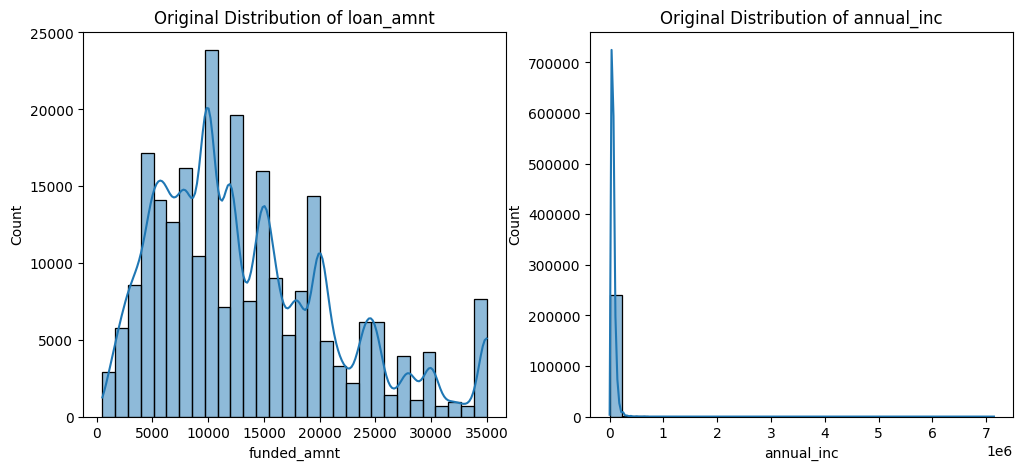

In [4]:
# @title Plotting the original distributions

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(loan_cleanup['funded_amnt'], bins=30, kde=True, ax=ax[0])
ax[0].set_title('Original Distribution of loan_amnt')
sns.histplot(loan_cleanup['annual_inc'], bins=30, kde=True, ax=ax[1])
ax[1].set_title('Original Distribution of annual_inc')
plt.show()

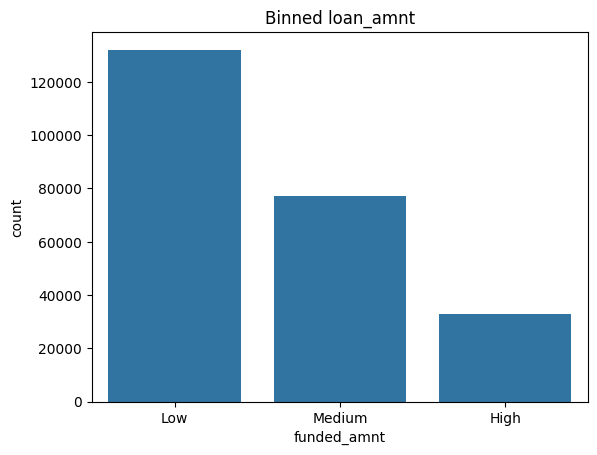

In [5]:
# @title Binning can catogorize continous variables into discrete categories
bins = pd.cut(loan_cleanup['funded_amnt'], bins=3, labels=["Low", "Medium", "High"])
sns.countplot(x=bins).set_title('Binned loan_amnt')
plt.show()

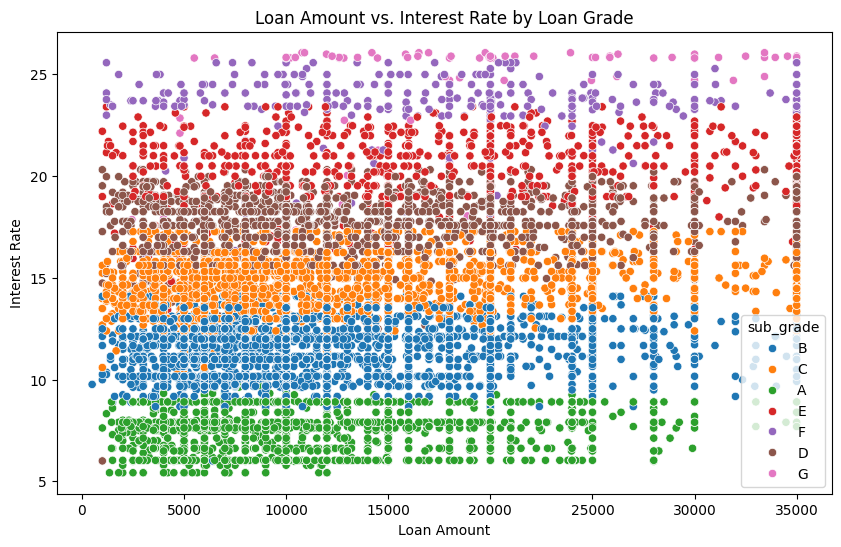

In [6]:
# @title Is there a relationship between loan amount and interest rate?
# Loan Amount vs. Interest Rate by Loan Grade
plt.figure(figsize=(10, 6))
sns.scatterplot(x='funded_amnt', y='int_rate', hue=loan_cleanup['sub_grade'].str.slice(0,1), data=loan_cleanup.sample(10000))
plt.title('Loan Amount vs. Interest Rate by Loan Grade')
plt.xlabel('Loan Amount')
plt.ylabel('Interest Rate')
plt.show()

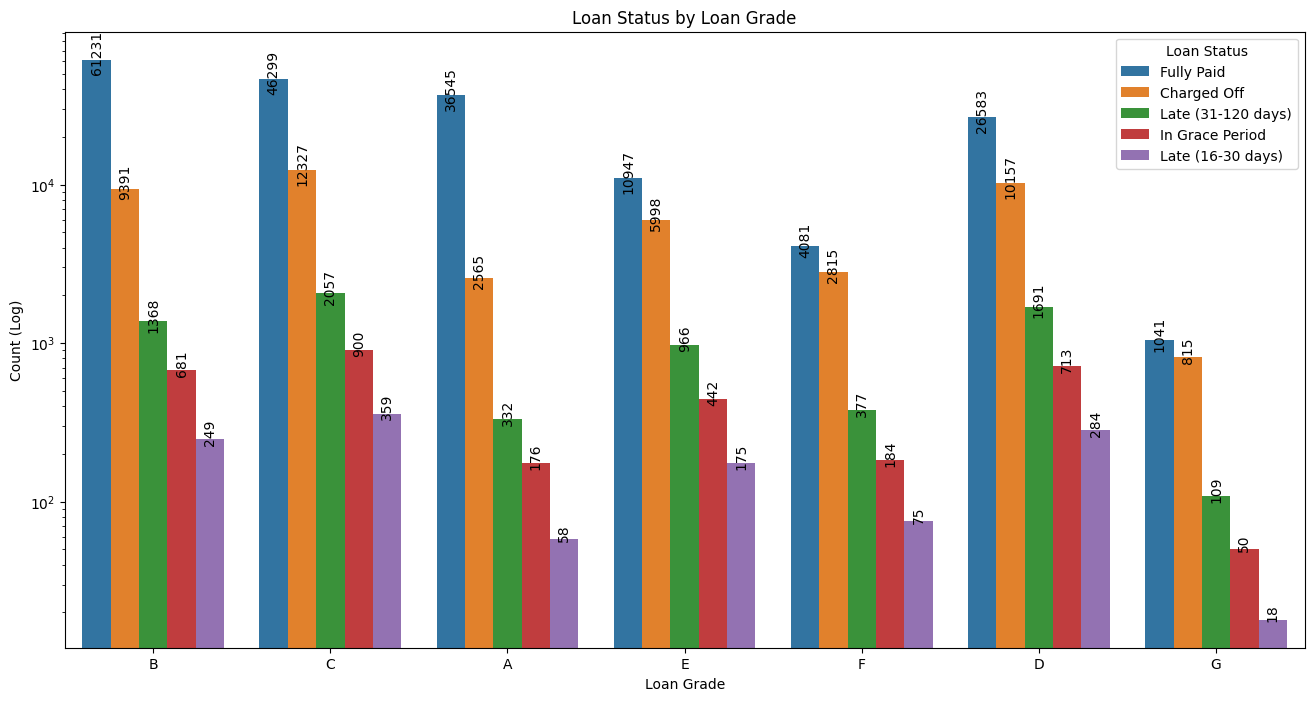

In [7]:
# @title How does the loan status vary across different loan grades?
plt.figure(figsize=(16, 8))
ax = sns.countplot(x=loan_cleanup['sub_grade'].str.slice(0,1), hue='loan_status', data=loan_cleanup)

plt.title('Loan Status by Loan Grade')
plt.xlabel('Loan Grade')
plt.ylabel('Count (Log)')
plt.yscale('log')
plt.legend(title='Loan Status')

# Manually annotate each bar with its count
for p in ax.patches:
    height = p.get_height() if p.get_height() == p.get_height() else 0 # Handle NaN values
    ax.annotate(format(height, '.0f'), (p.get_x() + p.get_width() / 2., height), ha = 'center', va = 'center',
                xytext = (0, 5), textcoords = 'offset points', rotation = 'vertical')

plt.show()

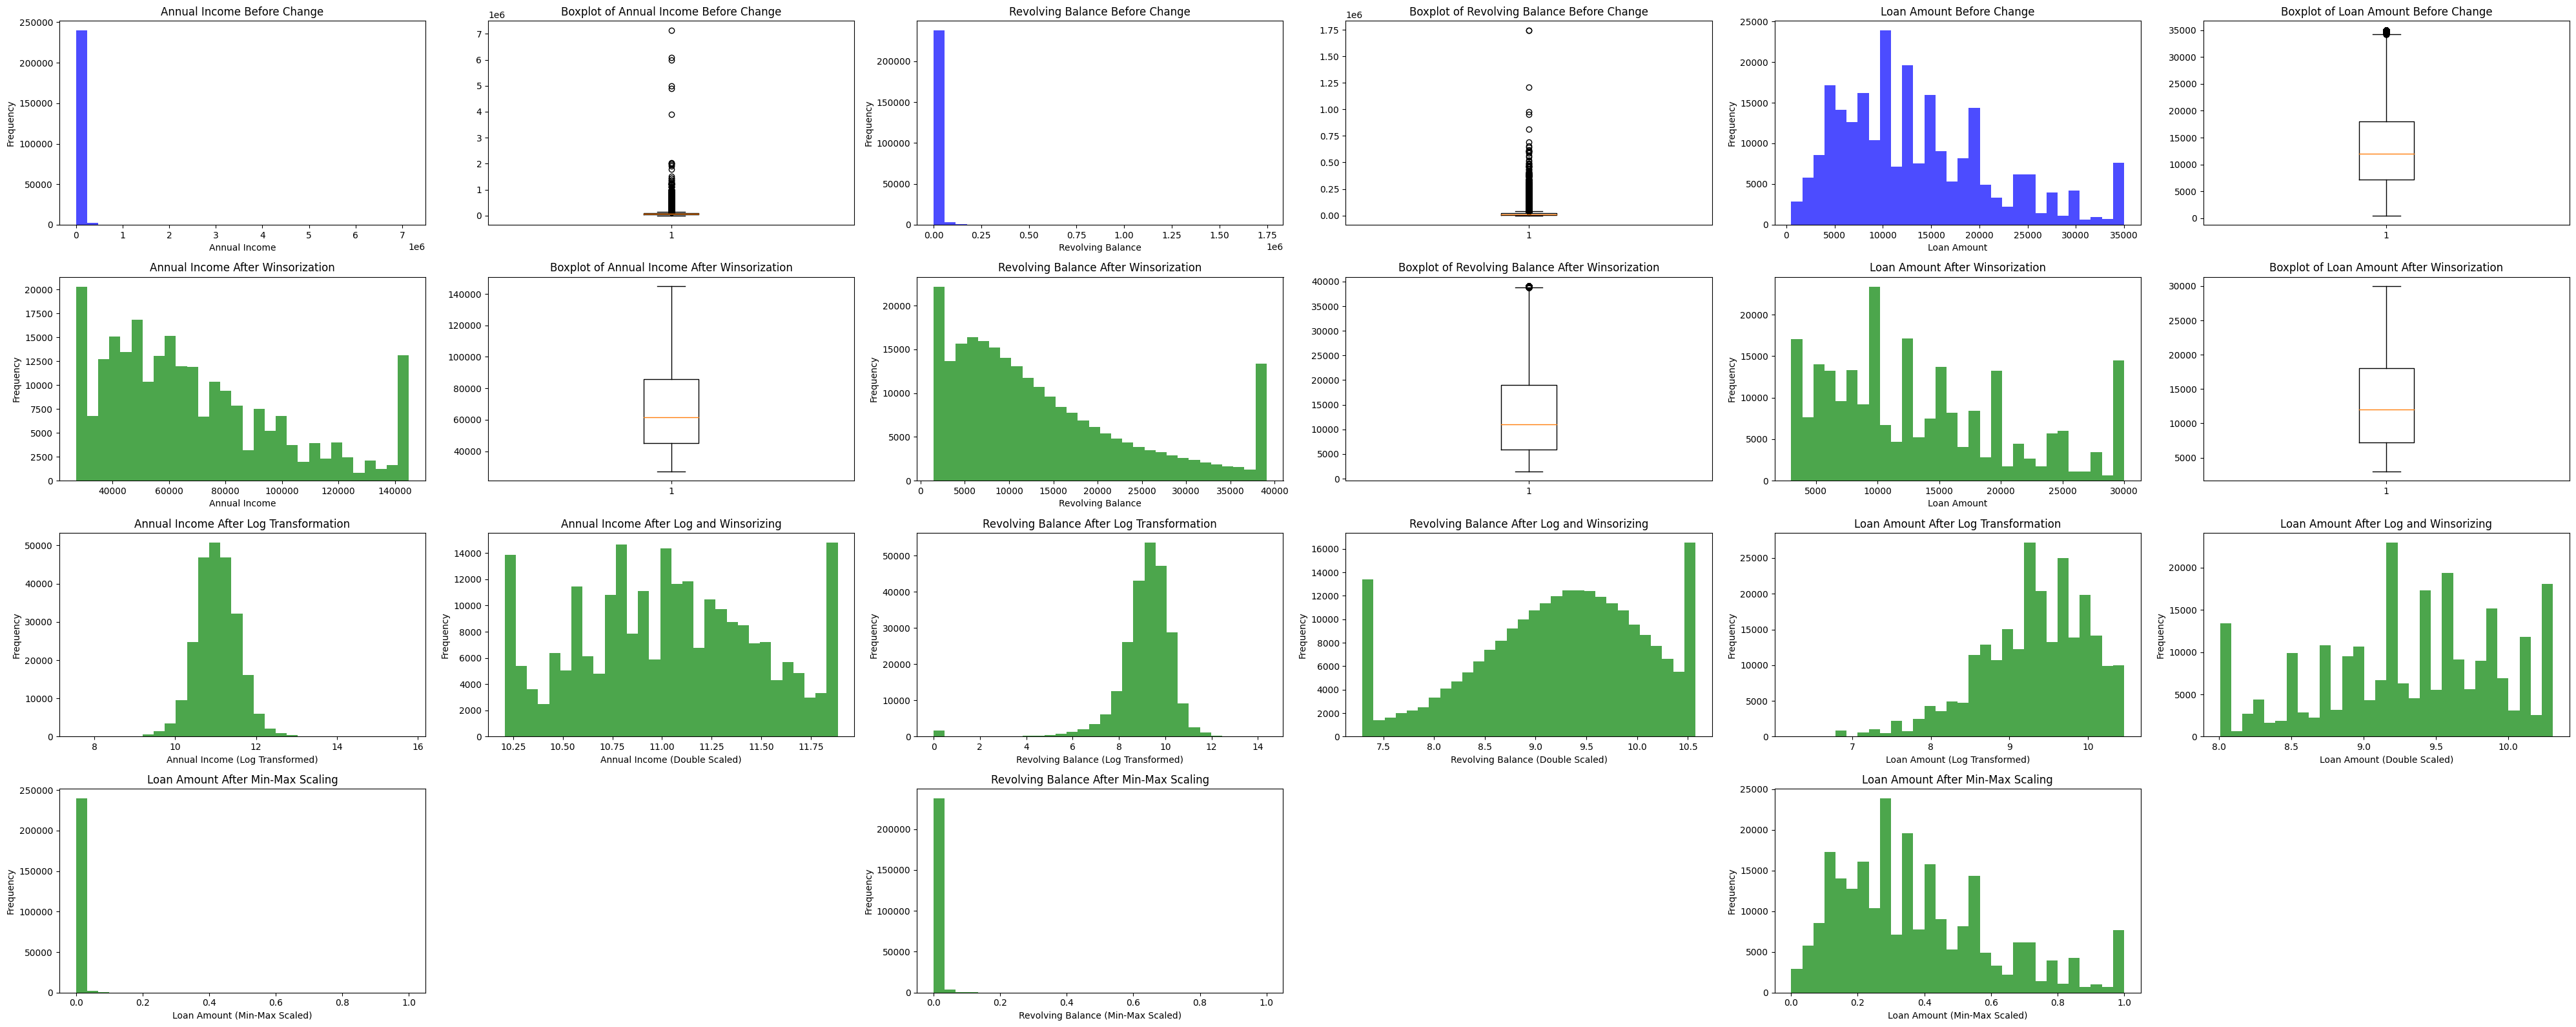

In [126]:
# @title Vishnu's Justification for Variable Scaling



# Handling outliers (winsorization)
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import MinMaxScaler
#loan_cleanup['win_annual_inc'] = winsorize(loan_cleanup['annual_inc'], limits=[0.05, 0.05])   #A# 43225 values changed.  Final Range: 28,000 - 150,000
#loan_cleanup['win_revol_bal'] = winsorize(loan_cleanup['revol_bal'], limits=[0.05, 0.05])     #A# 46617 values changed.  Final Range: 1,955 - 40,953

#loan_cleanup['log_funded_amnt'] = np.log1p(loan_cleanup['funded_amnt'])                               #A# This looks pretty skewed, too, though, just in the opposite direction
#loan_cleanup['log_annual_inc'] = np.log1p(loan_cleanup['annual_inc'])                                 #A# This looks pretty good for annual_inc
#loan_cleanup['log_revol_bal'] = np.log1p(loan_cleanup['revol_bal'])                                   #A# This looks pretty good for revolving balance

#scaler = MinMaxScaler()
#numerical_cols = ['funded_amnt', 'annual_inc', 'revol_bal']
#end_col_names = ['MinMax_funded_amnt','MinMax_annual_inc','MinMax_revol_bal']
#loan_cleanup[end_col_names] = scaler.fit_transform(loan_cleanup[numerical_cols])


# Plot histograms before transformations
plt.figure(figsize=(40, 16))
plt.subplot(4, 6, 1)
plt.hist(loan_cleanup['annual_inc'], bins=30, color='blue', alpha=0.7)
plt.title('Annual Income Before Change')
plt.xlabel('Annual Income')
plt.ylabel('Frequency')

plt.subplot(4, 6, 2)
plt.boxplot(loan_cleanup['annual_inc'])
plt.title('Boxplot of Annual Income Before Change')

plt.subplot(4, 6, 3)
plt.hist(loan_cleanup['revol_bal'], bins=30, color='blue', alpha=0.7)
plt.title('Revolving Balance Before Change')
plt.xlabel('Revolving Balance')
plt.ylabel('Frequency')

plt.subplot(4, 6, 4)
plt.boxplot(loan_cleanup['revol_bal'])
plt.title('Boxplot of Revolving Balance Before Change')

plt.subplot(4, 6, 5)
plt.hist(loan_cleanup['funded_amnt'], bins=30, color='blue', alpha=0.7)
plt.title('Loan Amount Before Change')
plt.xlabel('Loan Amount')
plt.ylabel('Frequency')

plt.subplot(4, 6, 6)
plt.boxplot(loan_cleanup['funded_amnt'])
plt.title('Boxplot of Loan Amount Before Change')

# Plot histograms after Winsorization
plt.subplot(4, 6, 7)
plt.hist(winsorize(loan_cleanup['annual_inc'], limits=[0.05, 0.05]), bins=30, color='green', alpha=0.7)
plt.title('Annual Income After Winsorization')
plt.xlabel('Annual Income')
plt.ylabel('Frequency')

plt.subplot(4, 6, 8)
plt.boxplot(winsorize(loan_cleanup['annual_inc'], limits=[0.05, 0.05]))
plt.title('Boxplot of Annual Income After Winsorization')

plt.subplot(4, 6, 9)
plt.hist(winsorize(loan_cleanup['revol_bal'], limits=[0.05, 0.05]), bins=30, color='green', alpha=0.7)
plt.title('Revolving Balance After Winsorization')
plt.xlabel('Revolving Balance')
plt.ylabel('Frequency')

plt.subplot(4, 6, 10)
plt.boxplot(winsorize(loan_cleanup['revol_bal'], limits=[0.05, 0.05]))
plt.title('Boxplot of Revolving Balance After Winsorization')

plt.subplot(4, 6, 11)
plt.hist(winsorize(loan_cleanup['funded_amnt'], limits=[0.05, 0.05]), bins=30, color='green', alpha=0.7)
plt.title('Loan Amount After Winsorization')
plt.xlabel('Loan Amount')
plt.ylabel('Frequency')

plt.subplot(4, 6, 12)
plt.boxplot(winsorize(loan_cleanup['funded_amnt'], limits=[0.05, 0.05]))
plt.title('Boxplot of Loan Amount After Winsorization')


# Plot histograms after Log Transformation
plt.subplot(4, 6, 13)
plt.hist(np.log1p(loan_cleanup['annual_inc']), bins=30, color='green', alpha=0.7)
plt.title('Annual Income After Log Transformation')
plt.xlabel('Annual Income (Log Transformed)')
plt.ylabel('Frequency')

plt.subplot(4, 6, 14)
plt.hist(np.log1p(winsorize(loan_cleanup['annual_inc'], limits=[0.05, 0.05])), bins=30, color='green', alpha=0.7)
plt.title('Annual Income After Log and Winsorizing')
plt.xlabel('Annual Income (Double Scaled)')
plt.ylabel('Frequency')

plt.subplot(4, 6, 15)
plt.hist(np.log1p(loan_cleanup['revol_bal']), bins=30, color='green', alpha=0.7)
plt.title('Revolving Balance After Log Transformation')
plt.xlabel('Revolving Balance (Log Transformed)')
plt.ylabel('Frequency')

plt.subplot(4, 6, 16)
plt.hist(np.log1p(winsorize(loan_cleanup['revol_bal'], limits=[0.05, 0.05])), bins=30, color='green', alpha=0.7)
plt.title('Revolving Balance After Log and Winsorizing')
plt.xlabel('Revolving Balance (Double Scaled)')
plt.ylabel('Frequency')

plt.subplot(4, 6, 17)
plt.hist(np.log1p(loan_cleanup['funded_amnt']), bins=30, color='green', alpha=0.7)
plt.title('Loan Amount After Log Transformation')
plt.xlabel('Loan Amount (Log Transformed)')
plt.ylabel('Frequency')

plt.subplot(4, 6, 18)
plt.hist(np.log1p(winsorize(loan_cleanup['funded_amnt'], limits=[0.05, 0.05])), bins=30, color='green', alpha=0.7)
plt.title('Loan Amount After Log and Winsorizing')
plt.xlabel('Loan Amount (Double Scaled)')
plt.ylabel('Frequency')

# Plot histograms after Min-Max scaling
scaler = MinMaxScaler()

plt.subplot(4, 6, 19)
plt.hist(scaler.fit_transform(loan_cleanup[['annual_inc']]), bins=30, color='green', alpha=0.7)
plt.title('Loan Amount After Min-Max Scaling')
plt.xlabel('Loan Amount (Min-Max Scaled)')
plt.ylabel('Frequency')

plt.subplot(4, 6, 21)
plt.hist(scaler.fit_transform(loan_cleanup[['revol_bal']]), bins=30, color='green', alpha=0.7)
plt.title('Revolving Balance After Min-Max Scaling')
plt.xlabel('Revolving Balance (Min-Max Scaled)')
plt.ylabel('Frequency')

plt.subplot(4, 6, 23)
plt.hist(scaler.fit_transform(loan_cleanup[['funded_amnt']]), bins=30, color='green', alpha=0.7)
plt.title('Loan Amount After Min-Max Scaling')
plt.xlabel('Loan Amount (Min-Max Scaled)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## EDA from Vishnu

<ipython-input-127-7085aeb1fee1>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette='Set3')


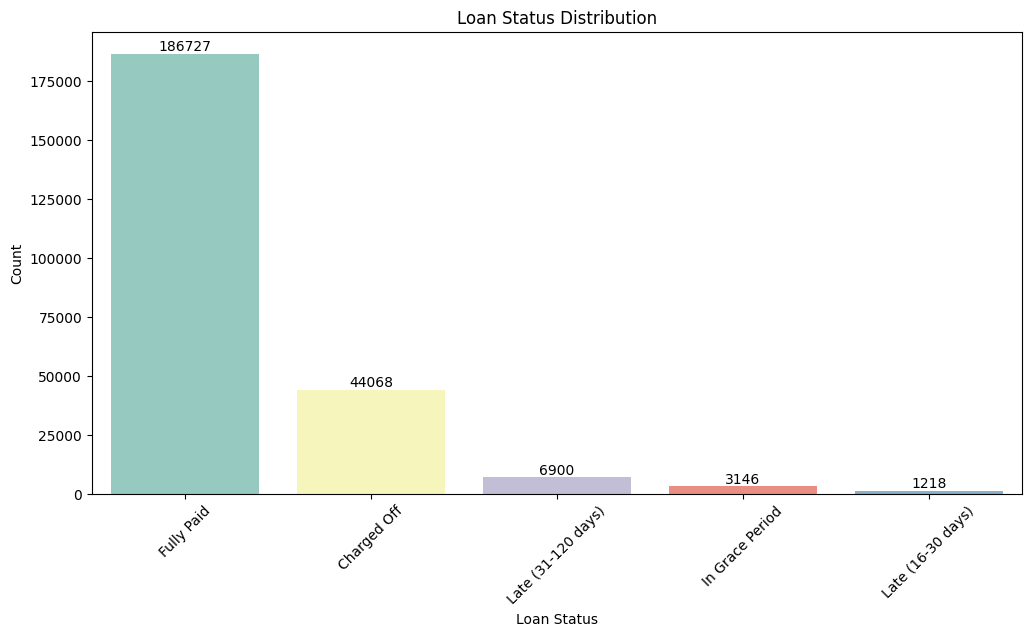

In [127]:
# @title What is the distribution of loan status in the dataset?

# Calculate value counts for loan_status
counts = loan_cleanup['loan_status'].value_counts()

plt.figure(figsize=(12, 6))
sns.barplot(x=counts.index, y=counts.values, palette='Set3')

plt.title('Loan Status Distribution')
plt.xlabel('Loan Status')
plt.ylabel('Count')

# Annotate each bar with its count
for i, count in enumerate(counts):
    plt.text(i, count + 0.1, str(count), ha='center', va='bottom')

plt.xticks(rotation=45)
plt.show()

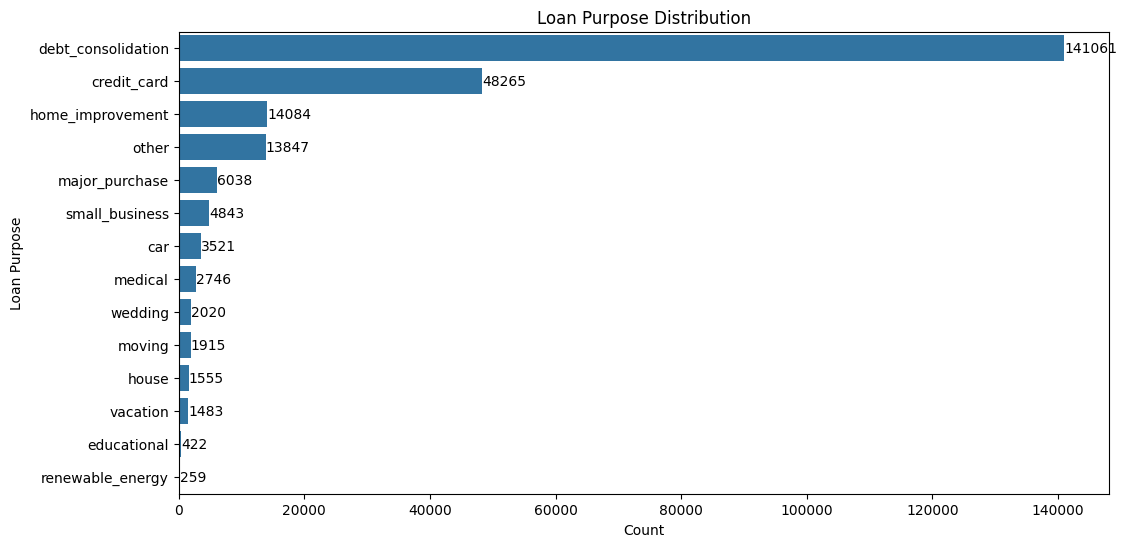

In [131]:
# @title What are the proportions of different loan purposes?
# Calculate value counts for loan purpose
counts = loan_cleanup['purpose'].value_counts()

plt.figure(figsize=(12, 6))
sns.countplot(y='purpose', data=loan_cleanup, order=loan_cleanup['purpose'].value_counts().index)

plt.title('Loan Purpose Distribution')
plt.xlabel('Count')
plt.ylabel('Loan Purpose')

# Annotate each bar with its count
for i, count in enumerate(counts):
    plt.text(count + 0.1, i, str(count), ha='left', va='center')

plt.show()

In [138]:
# @title How does the employment length affect the loan status?

grouped_data = loan_cleanup.groupby(['emp_length', 'loan_status']).size().reset_index(name='count')

# Creating the interactive plot
fig = px.bar(grouped_data, x='emp_length', y='count', color='loan_status',
             barmode='group', labels={'emp_length': 'Employment Length', 'count': 'Count (Log)',
                                       'loan_status': 'Loan Status'},
             title='Employment Length vs Loan Status',
             width=1500, height=600,log_y=True)

# Show the plot
fig.show()

<ipython-input-152-6f6e6c0bdaa6>:5: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



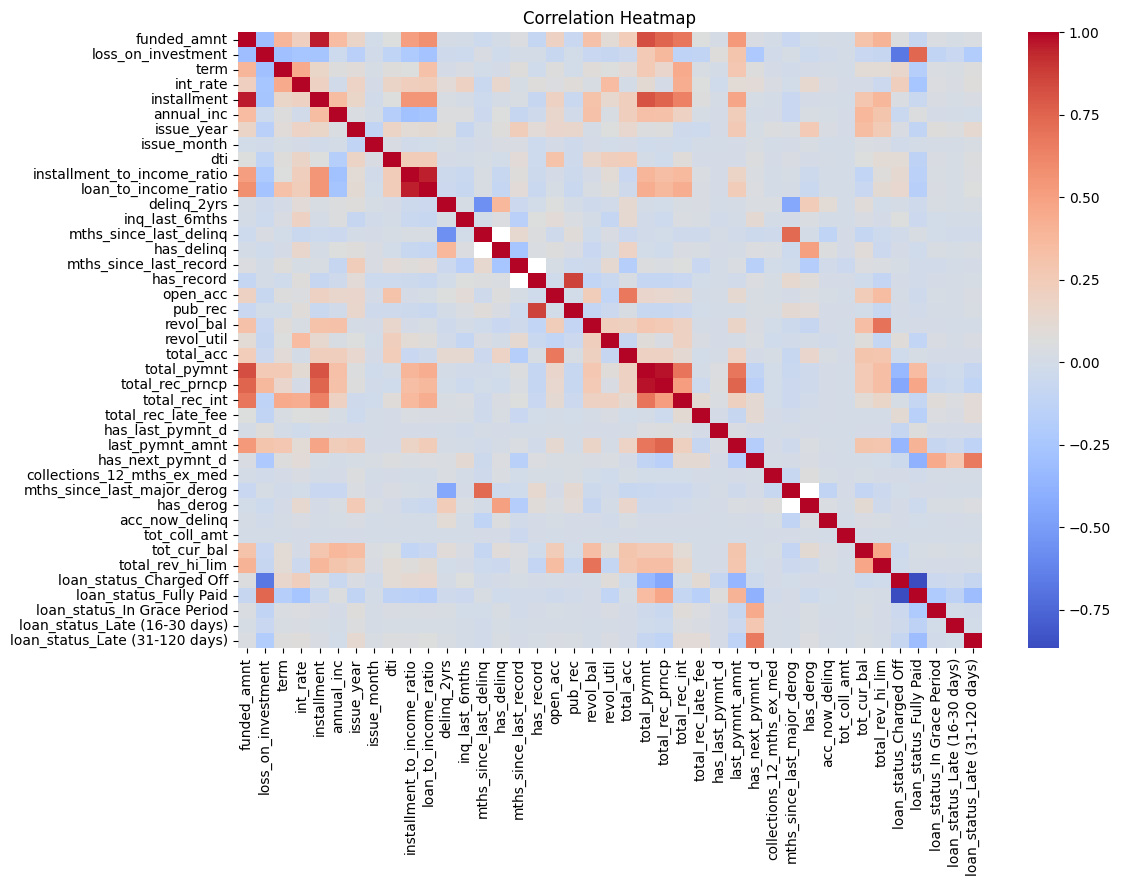

In [152]:
# @title What are the correlations between different variables in the data?

# Correlation Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pd.get_dummies(loan_cleanup, columns=['loan_status']).corr(),  cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

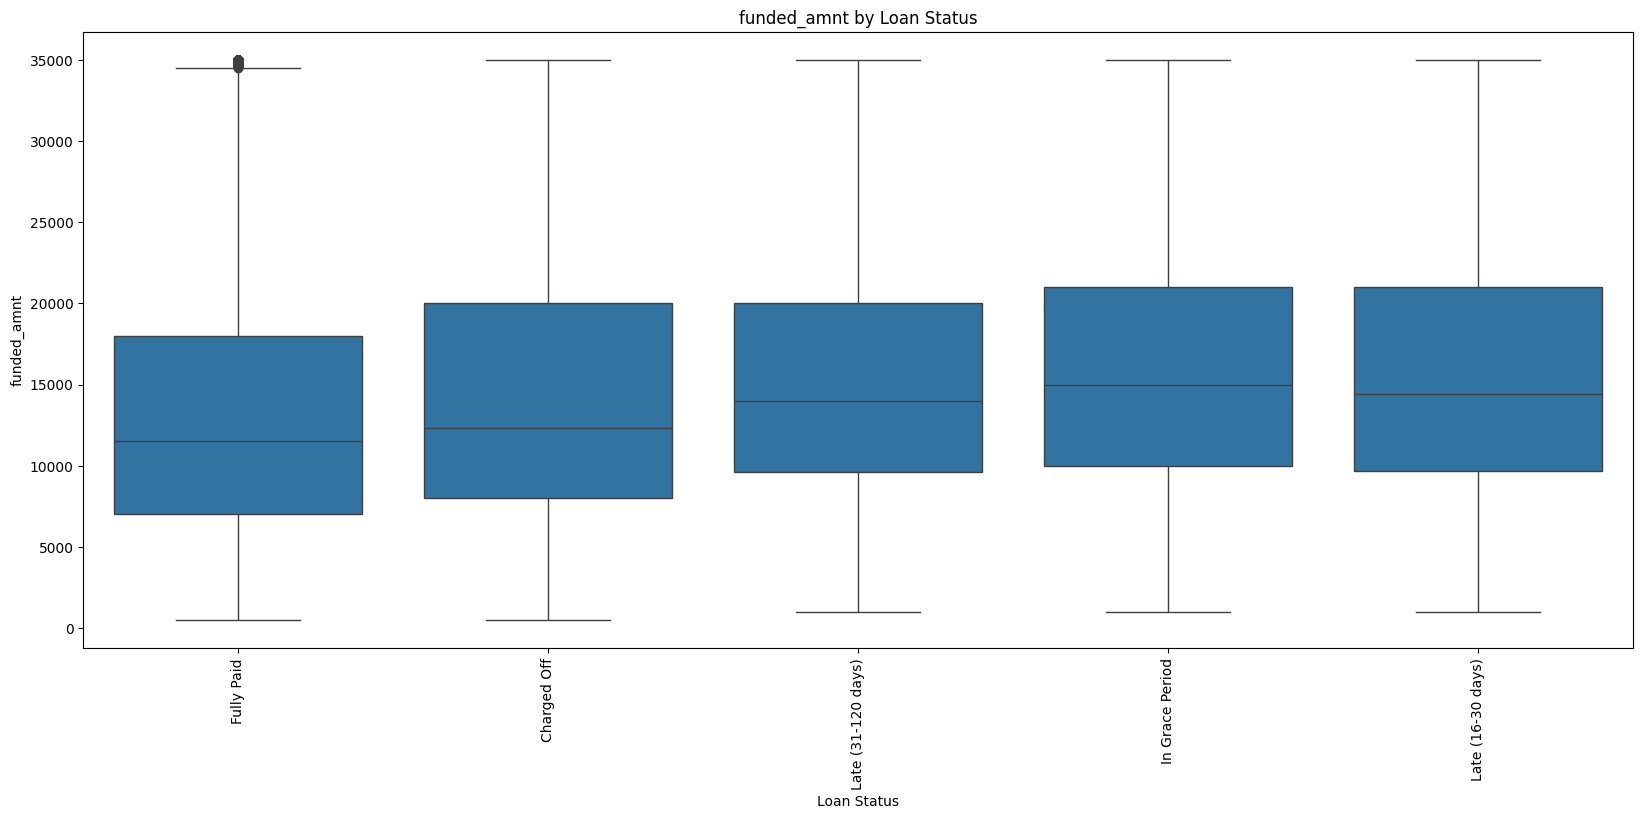

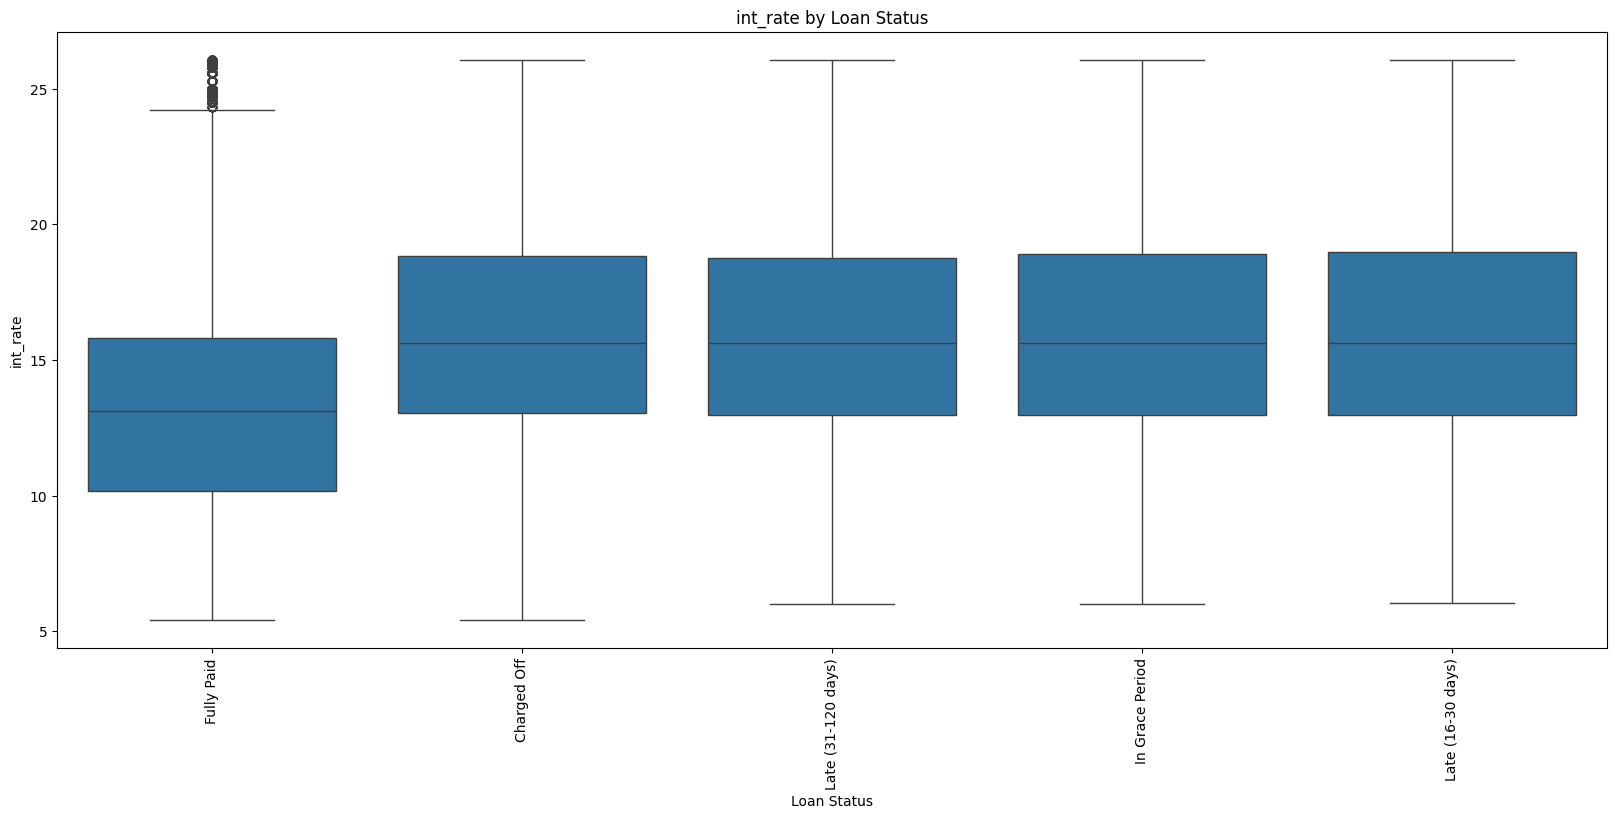

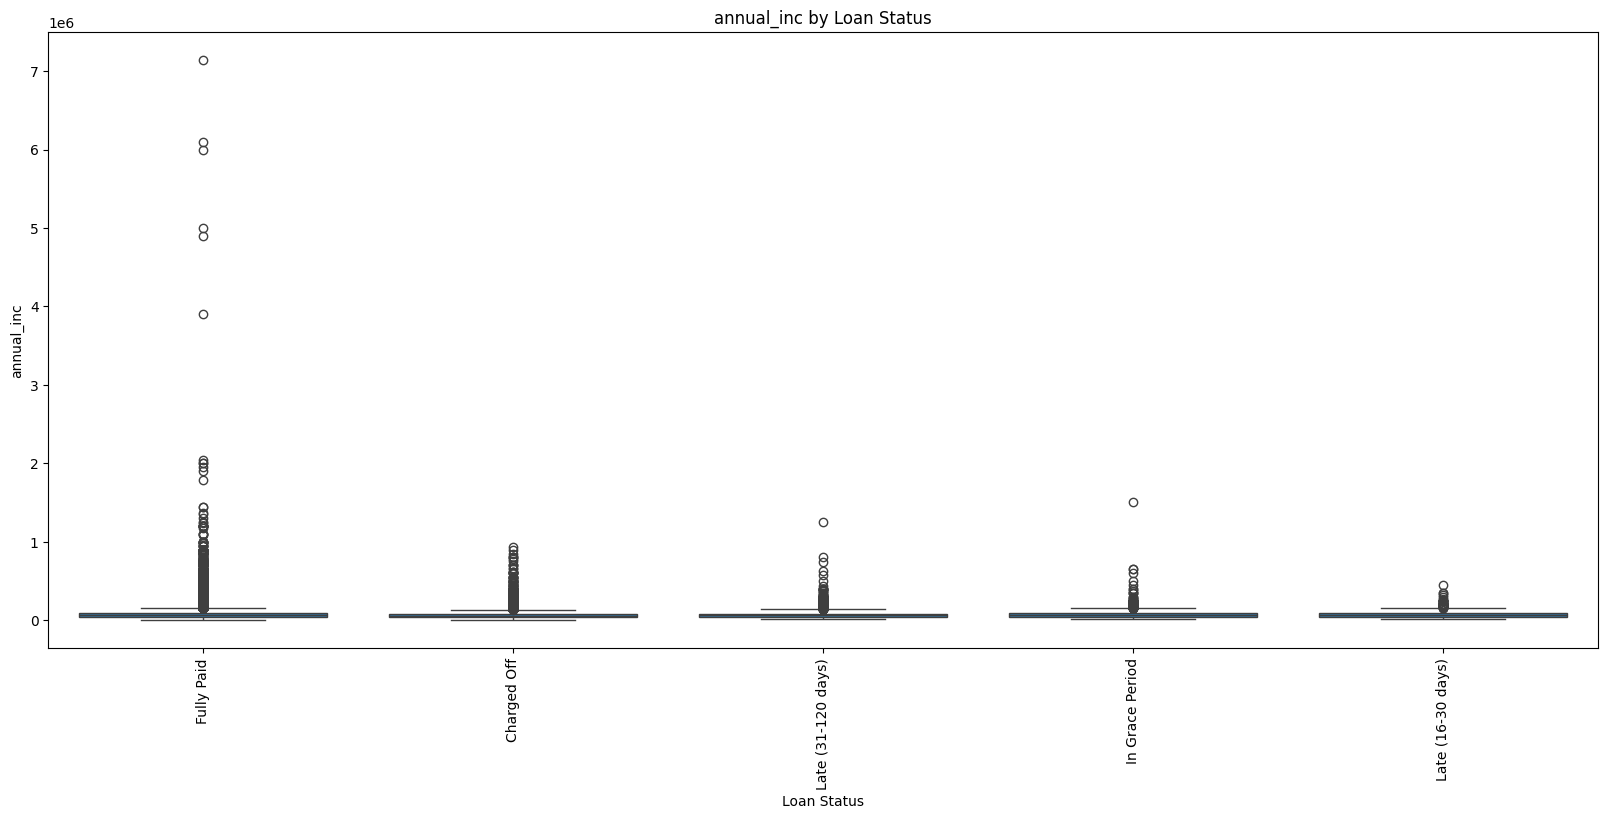

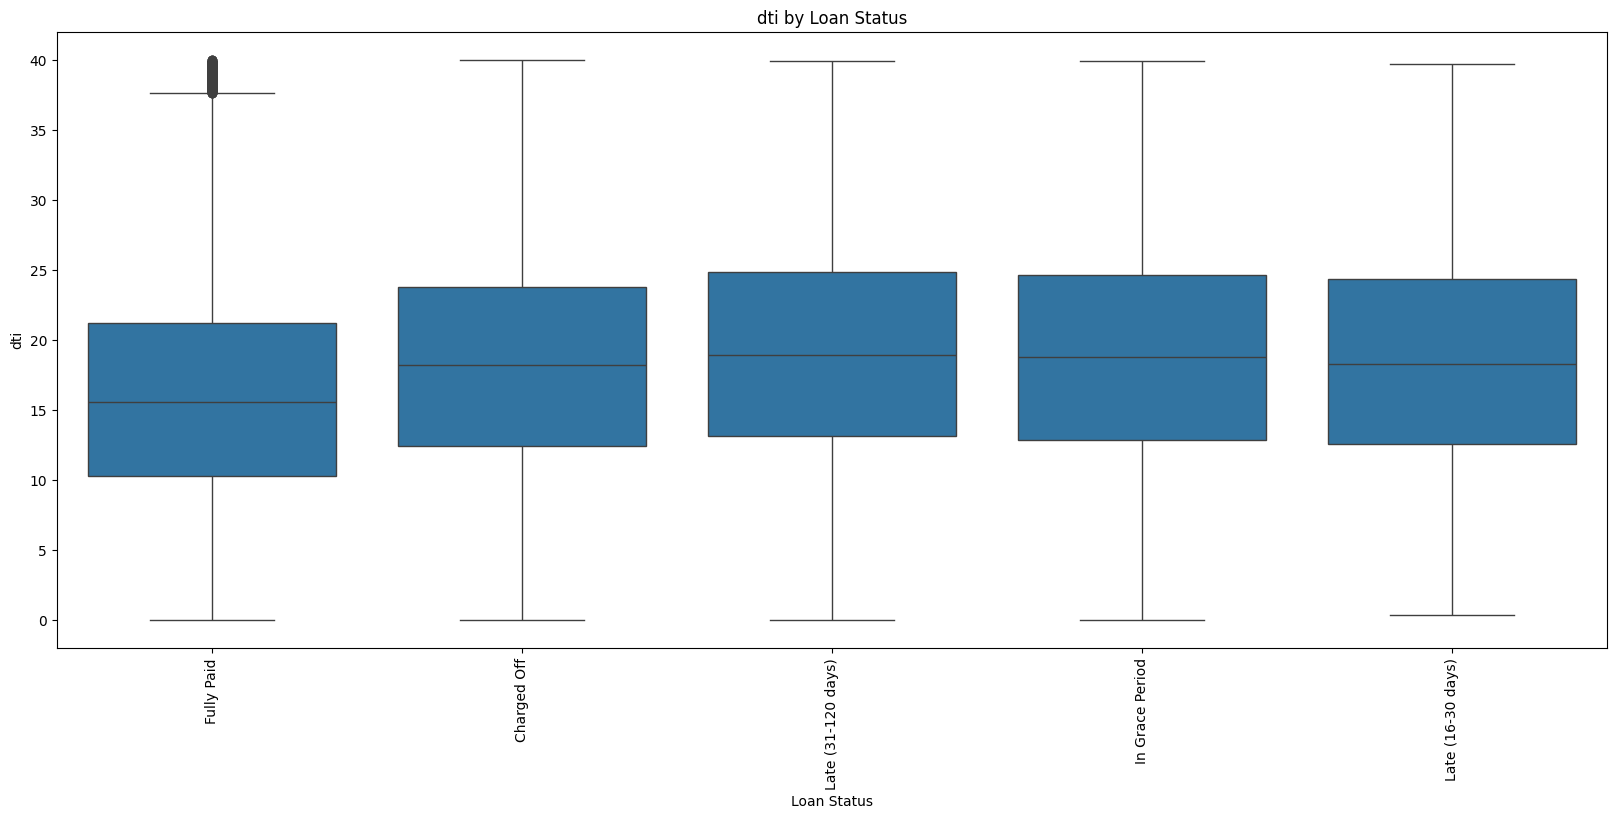

In [155]:
# @title How do the distributions of important numerical features vary between different loan statuses?

# Boxplot of Important Numerical Features by Loan Status
important_numerical_features = ['funded_amnt', 'int_rate', 'annual_inc', 'dti']
for feature in important_numerical_features:
    plt.figure(figsize=(20, 8))
    sns.boxplot(data=loan_cleanup, x='loan_status', y=feature)
    plt.title(f'{feature} by Loan Status')
    plt.xlabel('Loan Status')
    plt.ylabel(feature)
    plt.xticks(rotation=90)
    plt.show()

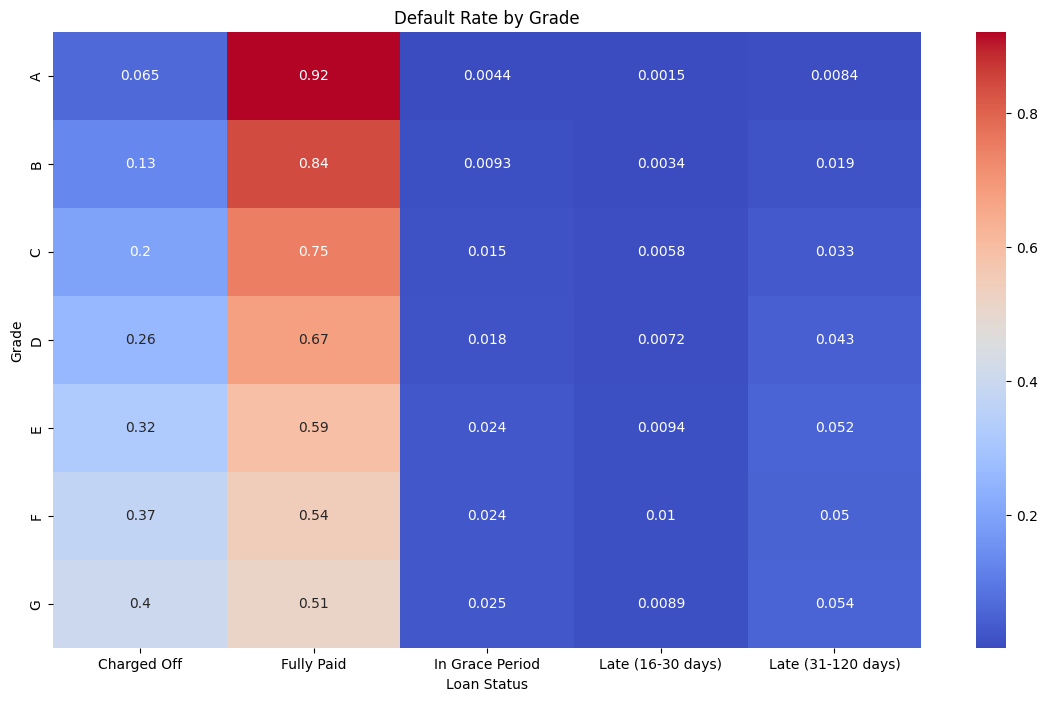

In [166]:
# @title How do the default rates vary across different loan grades?

# Default Rate by Grade
default_rate_by_grade = loan_cleanup.groupby(loan_cleanup['sub_grade'].str.slice(0,1))['loan_status'].value_counts(normalize=True).unstack()
plt.figure(figsize=(14, 8))
sns.heatmap(default_rate_by_grade, annot=True, cmap='coolwarm')
plt.title('Default Rate by Grade')
plt.xlabel('Loan Status')
plt.ylabel('Grade')
plt.show()

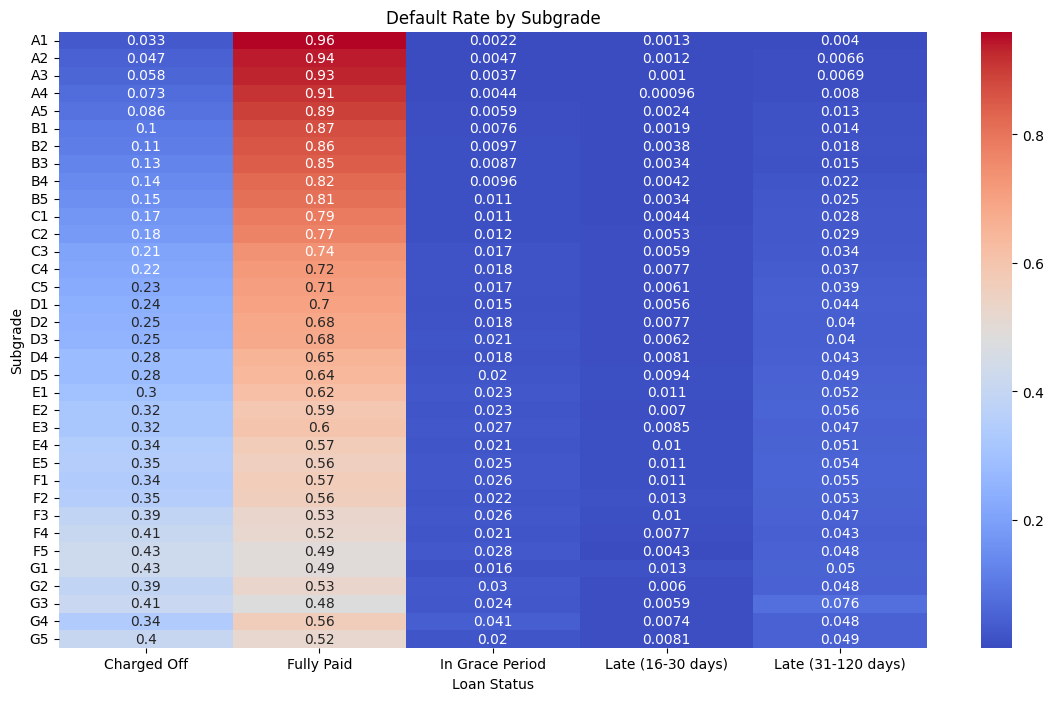

In [159]:
# @title How do the default rates vary across different loan subgrades?

# Default Rate by Subgrade
default_rate_by_subgrade = loan_cleanup.groupby('sub_grade')['loan_status'].value_counts(normalize=True).unstack()
plt.figure(figsize=(14, 8))
sns.heatmap(default_rate_by_subgrade, annot=True, cmap='coolwarm')
plt.title('Default Rate by Subgrade')
plt.xlabel('Loan Status')
plt.ylabel('Subgrade')
plt.show()

In [220]:
# @title How does the relationship between loan amount and interest rate vary based on loan status?
fig = px.scatter(loan_cleanup.sample(10000), x='funded_amnt', y='int_rate', color='loan_status',
                 title='Loan Amount vs. Interest Rate',
                 labels={'funded_amnt': 'Loan Amount', 'int_rate': 'Interest Rate'})
fig.show()

In [26]:
# @title What is the distribution of debt-to-income ratios for different loan statuses?

fig = px.histogram(loan_cleanup, x='dti', color='loan_status',
                   title='Debt-to-Income Ratio Distribution',
                   labels={'dti': 'Debt-to-Income Ratio'})
fig.show()

In [198]:
# @title How do default rates fluctuate over time?

# Time Series Analysis of Proportion of People Who Default

default_rate_over_time = loan_cleanup.groupby('issue_month')['loan_status'] \
    .apply(lambda x: ((x == 'Charged Off')).sum() / len(x)).reset_index(name='default_rate')

fig = px.line(default_rate_over_time, x='issue_month', y='default_rate',
              labels={'issue_d': 'Issue Date', 'default_rate': 'Default Rate'},
              title='Time Series Analysis of Proportion of People Who Default')

fig.show()

In [217]:
# @title How are the loan statuses separated in a lower-dimensional space using PCA?

# Principal Component Analysis (PCA) Visualization
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(loan_cleanup[['funded_amnt', 'int_rate', 'annual_inc', 'dti']])
loan_cleanup_df_pca = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
loan_cleanup_df_pca['loan_status'] = loan_cleanup['loan_status']

fig = px.scatter(loan_cleanup_df_pca.sample(5000), x='PC1', y='PC2', color='loan_status',
                 title='PCA Visualization of Important Numerical Features',
                 labels={'PC1': 'Principal Component 1', 'PC2': 'Principal Component 2'})
fig.show()


In [218]:
# @title What are the pairwise relationships between important numerical features and loan status?

fig = px.scatter_matrix(loan_cleanup.sample(1000), dimensions=['funded_amnt', 'int_rate', 'annual_inc', 'dti'], color='loan_status',
                        title='Leveraged Scatter Plot Matrix', template='plotly', width=1300, height=1300)
fig.update_traces(marker=dict(size=3))
fig.show()

## Other EDA

In [8]:
# @title Statewide Default Rates
states = loan_cleanup['addr_state'].unique()
paid =[];
default = [];

for x in states:
  paid.append(loan_cleanup.query(f'loan_status == "Fully Paid" & addr_state == "{x}"')['loan_status'].count())
  default.append(loan_cleanup.query(f'loan_status == "Charged Off" & addr_state == "{x}"')['loan_status'].count())

dat = pd.DataFrame(zip(states,paid,default), columns = ['states','fully paid','defaulted'])
dat['ratio'] = dat['defaulted']/dat['fully paid']

dat['percentage of defaults'] = dat['defaulted']/(dat['defaulted'] + dat['fully paid'])

display(dat.sort_values('percentage of defaults',ascending = False))

,states,fully paid,defaulted,ratio,percentage of defaults
46,NE,6,7,1.166667,0.538462
43,MS,210,80,0.380952,0.275862
44,TN,1551,542,0.349452,0.258958
48,IN,1811,587,0.324130,0.244787
45,IA,10,3,0.300000,0.230769
24,NV,2651,777,0.293097,0.226663
23,AL,2229,628,0.281741,0.219811
9,FL,12603,3463,0.274776,0.215548
35,NM,983,262,0.266531,0.210442
6,MO,2909,766,0.263321,0.208435
